In [2]:
import numpy as np
import matplotlib.pyplot as plt


Epoch:0, Loss:0.9641739249025809
Epoch:100, Loss:0.953748136431472
Epoch:200, Loss:0.9436444354962628
Epoch:300, Loss:0.9160141388479469
Epoch:400, Loss:0.8672998081150322
Epoch:500, Loss:0.8155019455205451
Epoch:600, Loss:0.76941078876084
Epoch:700, Loss:0.7248699711808537
Epoch:800, Loss:0.6772459330741205
Epoch:900, Loss:0.6255785608677749
Epoch:1000, Loss:0.5730380827774829


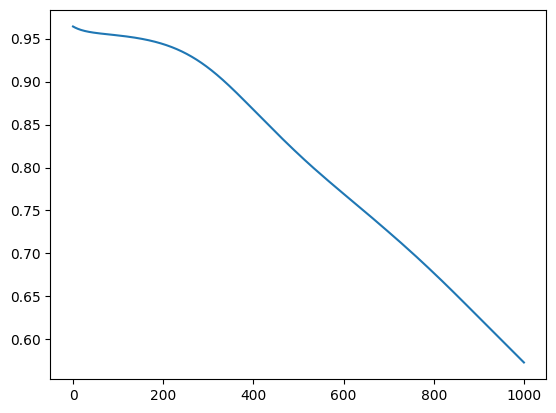

(100, 10)


In [4]:



def mse_loss(y_true,y_pred):
    """
    Compute the mean squared error loss between the true and predicted values (the cost function)
    """
    return np.mean(np.square(y_true-y_pred))
    

def derivative_mse_loss(y_true,y_pred):
    """
    Compute the derivative of the mean squared error loss function with respect to the predicted values
    input:
    y_true: numpy array, dimensions (batch_size,seq_len,d_model), the true values
    y_pred: numpy array, dimensions (batch_size,seq_len,d_model), the predicted values
    output:
    numpy array, dimensions (batch_size,seq_len,d_model), the derivative of the loss function with respect to the predicted values 
    """

    return 2*(y_pred-y_true)/y_true.shape[0]
def Relu(x):
    return np.maximum(0,x)
def Relu_derivative(x):
    return np.where(x>0,1,0)
class TransfomerFF:
    def __init__(self,d_model=4,max_seq_len=100,units=2048,batch_size=32,name="FF_layer_X"):
            self.d_model = d_model
            self.max_seq_len = max_seq_len
            self.batch_size = batch_size
            self.weights1 = None
            self.weights2 = None
            self.bias1 = None
            self.bias2 = None
            self.name = name
            self.units = units # the number of units in the hidden layer
    def init_weights(self,weights_mode="random",weights1=None,weights2=None,bias1=None,bias2=None):
        """
        Initialize the weights of the model
        
        Parameters:
        
        weights_mode: str, the mode of the weights initialization, can be "random" or "pretrained"
        weights1: numpy array, the weights of the first layer
        weights2: numpy array, the weights of the second layer
        bias1: numpy array, the bias of the first layer
        bias2: numpy array, the bias of the second layer
        
        """
        
        if weights_mode=="random":
            self.weights1 = np.random.randn(self.d_model,self.units)*0.01
            self.weights2 = np.random.randn(self.units,self.d_model)*0.01
            self.bias1 = np.zeros((1, self.units)) #np.random.randn(1,self.units)
            self.bias2 =  np.zeros((1, self.d_model)) #  np.random.randn(1,self.d_model)
        elif weights_mode=="pretrained":
            # check if the weights are provided and if they are of the correct shape
            if (weights1 is None or weights2 is None or 
                bias1 is None or bias2 is None):
                raise ValueError("weights1, weights2, bias1, and bias2 must be provided for pretrained mode.")
            assert weights1.shape == (self.d_model,self.units)
            assert weights2.shape == (self.units,self.d_model)
            assert bias1.shape == (1,self.units)
            assert bias2.shape == (1,self.d_model)
            
            self.weights1 = weights1
            self.weights2 = weights2
            self.bias1 = bias1
            self.bias2 = bias2
            
        elif weights_mode == "null":
            self.weights1 = np.zeros((self.d_model,self.units))
            self.weights2 = np.zeros((self.units,self.d_model))
            self.bias1 = np.zeros((1,self.units))
            self.bias2 = np.zeros((1,self.d_model))
    def forward_old(self,inputs):
        
        # create the first hidden layer
        z1 = np.dot(inputs,self.weights1) + self.bias1
        
        
        a1 = np.maximum(0,z1)
        
        # create the second hidden layer
        
        z2 = np.dot(a1,self.weights2) + self.bias2
        
        return z2
    """
    def forward(self, inputs):
        # X shape: (batch_size, max_seq_len, d_model)
        self.batch_size, self.max_seq_len, _ = inputs.shape
        # Reshape X to 2D for easier computation
        X_reshaped = inputs.reshape(-1, self.d_model)
        # First layer
        self.Z1 = np.dot(X_reshaped, self.weights1) + self.bias1
        
        # apply the activation function -  Leaky ReLU
        self.A1 = np.maximum(0, self.Z1)  # ReLU activation
            
        # Second layer
        Z2 = np.dot(self.A1, self.weights2) + self.bias2
            
        # Reshape output back to 3D
        return Z2.reshape(self.batch_size, self.max_seq_len, self.d_model)
    """
    def forward_without_batch(self,inputs):
        # inputs shape: (seq_len,d_model)
        z1 = np.dot(inputs,self.weights1) + self.bias1
        a1 = Relu(z1)
        z2 = np.dot(a1,self.weights2) + self.bias2
        return z2
    def backprop_without_batch(self,inputs,targets):
        
        """
        inputs: numpy array, dimensions (seq_len,d_model), the input data
        targets: numpy array, dimensions (seq_len,d_model), the target values
        """
        
        # create the gradient arrays
        grad_weights1 = np.zeros_like(self.weights1)
        grad_weights2 = np.zeros_like(self.weights2)
        grad_bias1 = np.zeros_like(self.bias1)
        grad_bias2 = np.zeros_like(self.bias2)
        
        # feed forward pass
        
        z_layer_1 = np.dot(inputs,self.weights1) + self.bias1
        a_layer_1 = Relu(z_layer_1)
        
        z_layer_2 = np.dot(a_layer_1,self.weights2) + self.bias2

        # delta is gradient of the cost with respect to z at the output layer ( using BP1 formula)
        
        delta=derivative_mse_loss(targets,z_layer_2) 
        
        grad_weights2 = np.dot(a_layer_1.T,delta) # or np.dot(delta,a_layer_1.T) TO VERIFY THE DIMENSIONS
        
        grad_bias2 = delta.sum(axis=0,keepdims=True)
  
        #grad_bias2 = delta
        
        delta = np.dot(delta,self.weights2.T) * Relu_derivative(z_layer_1)
        grad_weights1 = np.dot(inputs.T,delta)
        grad_bias1 = delta.sum(axis=0,keepdims=True)
        #grad_bias1 = delta
        
        return [grad_weights1,grad_weights2,grad_bias1,grad_bias2]
        
        
    def update_weights(self,parameters,learning_rate=0.01):
        self.weights1 -= learning_rate*parameters[0]
        self.weights2 -= learning_rate*parameters[1]
        self.bias1 -= learning_rate*parameters[2]
        self.bias2 -= learning_rate*parameters[3]
    
    
    #def forward_without_batch(self,inputs):
    #    z1 = np.dot(inputs,self.weights1) + self.bias1
    #    a1 = np.maximum(0.01*z1,z1)
    #    z2 = np.dot(a1,self.weights2) + self.bias2
    #    return z2
    def predict(self,inputs):
        return self.forward_without_batch(inputs)
    def backprop_batch(self):
        pass
    def update_weights_batch(self):
        pass
    def train_batch(self):
        pass
    def train_without_batch(self,x,y,epoch=1001,learning_rate=0.1):
        loss_to_epoch_history=[]
        
        for epoch in range(epoch):
            pred=self.forward_without_batch(x)
            loss=mse_loss(y,pred)
            loss_to_epoch_history.append((epoch,loss))
            if epoch%100==0:
                print(f"Epoch:{epoch}, Loss:{loss}")
            params=self.backprop_without_batch(x,y)
            self.update_weights(params,learning_rate)
        plt.plot(*zip(*loss_to_epoch_history))
        plt.show()
        return [self.weights1,self.weights2,self.bias1,self.bias2],loss_to_epoch_history

d_model=10
max_seq_len=100
units=100
learning_rate=0.01

ffn=TransfomerFF(d_model=d_model,max_seq_len=max_seq_len,units=units) 
ffn.init_weights(weights_mode="random")
X_train = np.random.randn(max_seq_len, d_model) # 100 samples, each with d_model features
y_train = np.random.randn(max_seq_len,d_model)  # 100 target values


#ffn.forward(X_train).shape
ffn.train_without_batch(X_train, y_train, epoch=1001, learning_rate=learning_rate)
ffn.predict(X_train).shape
print(y_train.shape)